In [1]:
%%configure -f
{ "conf":{
     "spark.pyspark.python": "python3"
    ,"spark.pyspark.virtualenv.enabled": "true"
    ,"spark.kubernetes.executor.node.selector.node-lifecycle":"spot"
    ,"spark.pyspark.virtualenv.type":"native"
    ,"spark.pyspark.virtualenv.bin.path":"/usr/bin/virtualenv"
    ,"spark.sql.files.ignoreCorruptFiles":"true"
    ,"spark.dynamicAllocation.executorIdleTimeout":"18000"
    ,"spark.driver.memory":"32g"
    ,"spark.driver.cores":"32"
    ,"spark.driver.maxResultSize":"24g"
    ,"spark.executor.memory":"32g"
    ,"spark.network.timeout":"300"
    ,"spark.executor.cores":"8"
    ,"spark.dynamicAllocation.maxExecutors":"500"
    ,"spark.dynamicAllocation.minExecutors":"1"
    ,"livy.server.session.timeout":"24h"
    ,"spark.sql.shuffle.partitions":"10000"
    }
}  

[I 2024-06-18 11:50:00,919.919 configure_magic] Magic cell payload received: {"conf": {"spark.pyspark.python": "python3", "spark.pyspark.virtualenv.enabled": "true", "spark.kubernetes.executor.node.selector.node-lifecycle": "spot", "spark.pyspark.virtualenv.type": "native", "spark.pyspark.virtualenv.bin.path": "/usr/bin/virtualenv", "spark.sql.files.ignoreCorruptFiles": "true", "spark.dynamicAllocation.executorIdleTimeout": "18000", "spark.driver.memory": "32g", "spark.driver.cores": "32", "spark.driver.maxResultSize": "24g", "spark.executor.memory": "32g", "spark.network.timeout": "300", "spark.executor.cores": "8", "spark.dynamicAllocation.maxExecutors": "500", "spark.dynamicAllocation.minExecutors": "1", "livy.server.session.timeout": "24h", "spark.sql.shuffle.partitions": "10000"}, "proxyUser": "assumed-role_WSParticipantRole_Participant"}

[I 2024-06-18 11:50:00,919.919 configure_magic] Sending request to update kernel. Please wait while the kernel will be refreshed.


The kernel is successfully refreshed.

In [154]:
import pyspark.sql.functions as f
import pyspark.sql.types as t
from pyspark.sql.window import Window
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import warnings # To suppress some warnings
import os
import hashlib
# Suppress the specific FutureWarning
warnings.filterwarnings("ignore", category=FutureWarning, module="seaborn")
os.environ["PYARROW_IGNORE_TIMEZONE"] = "1"

s3_path='s3://demomayst/parquet_mst/'
s3_working_dir='s3://demomayst/cache/'
# col('ReceiptTimestamp') is in nano seconds in UTC timezone so we convert it to unix timestamp in exchange timezone
# keeping first 10 digits and then convert it pySpark timestamp, 
f_hour_from_ns_ts= f.from_utc_timestamp(f.from_unixtime(f.col('ReceiptTimestamp').cast(t.StringType())[0:10]),'America/New_York').cast(t.StringType())[12:2]
select_cols = ['f','Feed','SequenceNumber','Product','ReceiptTimestamp','dt']
nbbo_df= spark.read.parquet(f'{s3_path}mt=nbbo_quote/').where('Feed=="OPRA"').select(select_cols+['BidPrice','BidQuantity','AskPrice','AskQuantity','BestBidParticipant','BestAskParticipant'])\
    .withColumn('dtHour', f_hour_from_ns_ts)\
    .withColumn("ProductUnderlier",f.split(f.col("Product"), ' ', -1).getItem(0))\
    .withColumn("bid_ask_spread",(f.col('AskPrice')-f.col('BidPrice'))/f.col('BidPrice'))\
    .withColumn("mid_price",(f.col('AskPrice')+f.col('BidPrice'))/f.lit(2))
trade_df= spark.read.parquet(f'{s3_path}mt=trade/').where('Feed=="OPRA"')\
    .select(select_cols+['Price','Quantity','Side','OrderReferenceNumber','LeavesQuantity','MarketParticipant'])\
    .withColumn('dtHour', f_hour_from_ns_ts)\
    .withColumn("ProductUnderlier",f.split(f.col("Product"), ' ', -1).getItem(0))
order_df= spark.read.parquet(f'{s3_path}mt=add_order/').select(select_cols+['Price','Quantity','Side','OrderReferenceNumber']).withColumn('dtHour', f_hour_from_ns_ts)
one_mill_const = 1000000

In [2]:
trade_df.groupBy('Feed').agg(f.min('dt').alias('start_date'),f.max('dt').alias('end_date')).show()
nbbo_df.groupBy('Feed').agg(f.min('dt').alias('start_date'),f.max('dt').alias('end_date')).show()
order_df.groupBy('Feed').agg(f.min('dt').alias('start_date'),f.max('dt').alias('end_date')).show()

+----+----------+----------+
|Feed|start_date|  end_date|
+----+----------+----------+
|OPRA|2023-05-17|2023-05-18|
+----+----------+----------+

+----+----------+----------+
|Feed|start_date|  end_date|
+----+----------+----------+
|OPRA|2023-05-17|2023-05-18|
+----+----------+----------+

+-----+----------+----------+
| Feed|start_date|  end_date|
+-----+----------+----------+
|XDPV2|2023-02-23|2023-02-24|
+-----+----------+----------+



## VOLUME ANALYSIS SECTION ##

In [155]:
#calculate trade $ volume and count per exchange
trade_df.groupBy(['feed','MarketParticipant']).agg((f.sum(f.col('Quantity') * f.col('Price'))/f.lit(one_mill_const)).cast('float').alias("DollarVolume(Million)"),
                           f.count('SequenceNumber').alias("NumOfOrders")).orderBy(['MarketParticipant']).pandas_api()\
.style.format(thousands=',',precision=0).background_gradient()

,feed,MarketParticipant,DollarVolume(Million),NumOfOrders
0,OPRA,BATS,10,"625,726"
1,OPRA,BOX,45,"466,403"
2,OPRA,C2,7,"470,913"
3,OPRA,CBOE,186,"2,429,509"
4,OPRA,EDGX_OPTIONS,8,"697,274"
5,OPRA,ISE,24,"771,279"
6,OPRA,ISE_GEMINI,8,"224,622"
7,OPRA,ISE_MERCURY,3,"175,108"
8,OPRA,MIAX,12,"1,327,870"
9,OPRA,MIAX_EMERALD,6,"414,067"


In [156]:
# below we calculate the following metrics grouped per hour
# trade volume and number of orders per exchangetrade volume and number of orders per hour across all exchanges
trade_df_analysis = trade_df\
.groupBy(['dtHour']).agg(
     f.countDistinct('OrderReferenceNumber').alias("NumOfOrders"),
    f.round(f.sum(f.col('Quantity') * f.col('Price'))/f.lit(one_mill_const),0).cast('float').alias("DollarVolume(Million)")
                        ).orderBy(['dtHour']).cache()

trade_df_analysis.pandas_api().style.format(thousands=',',precision=0).background_gradient()
# what you need to do:
# calculate the overall trading volume for work hours vs after-hours 
# calculating distinct values over high-cardinality column may be expensive, you can try calcualting approximate distinct count and see what performance improvements it brings.   

,dtHour,NumOfOrders,DollarVolume(Million)
0,00,0,0
1,01,0,0
2,02,0,0
3,03,0,0
4,04,0,0
5,05,0,0
6,06,0,0
7,07,0,0
8,08,0,1
9,09,0,29


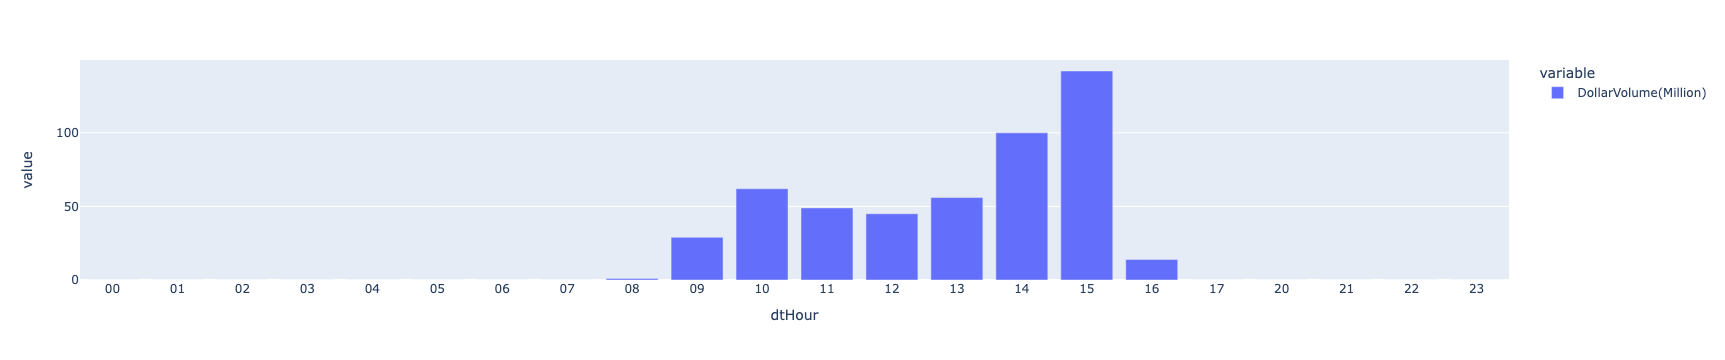

In [157]:
#plot line graph based on spark query results using seaborn
#import seaborn as sns
#sns.set_theme()
#ax = sns.relplot(
#    data=order_df_analysis.select('dtHour','DollarVolume').withColumn('DollarVolume(millions)',f.col('DollarVolume')/1000000).orderBy('dtHour').toPandas(), 
#    height=3, aspect=3.5, kind='line',
#    x="dtHour", y="DollarVolume(millions)"
#) 
trade_df_analysis.pandas_api().set_index('dtHour')[['DollarVolume(Million)']].plot.bar()

In [158]:
# get some individual tickers to analyse
sample_tickers=['AMZN','MSFT','GS','GE']
# calculate daily volumes for those tickers
plot_df = trade_df.filter(trade_df.ProductUnderlier.isin(sample_tickers)).select(
    f.col('dtHour'),'dt', 'ProductUnderlier', 'Quantity', 'Price','MarketParticipant','Feed')\
    .groupBy('dt','dtHour','ProductUnderlier','MarketParticipant','Feed')\
    .agg(f.sum(f.col('Quantity')*f.col('Price')/f.lit(one_mill_const)).alias('DollarVolume(Millions)')
).cache()

#calculate percentage of stock's volume on given exchange vs total volume on all exchanges(Feed) per hour of the day
plot_df=plot_df.withColumn('Percent',  
    (100*f.col('DollarVolume(Millions)'))/f.sum('DollarVolume(Millions)').over(Window.partitionBy(['dt','dtHour','ProductUnderlier']))
)

#calculate percentage of stock's volume on given exchange per hour across all days vs total stock volume on all exchanges(Feed) per hour across all days
plot_df=plot_df.withColumn('PercentHour',  
    (100*f.sum('DollarVolume(Millions)').over(Window.partitionBy(['dtHour','ProductUnderlier','MarketParticipant'])))/f.sum('DollarVolume(Millions)').over(Window.partitionBy(['dtHour','ProductUnderlier']))
)

plot_df.show()

+----------+------+----------------+-----------------+----+----------------------+---------+-----------+
|        dt|dtHour|ProductUnderlier|MarketParticipant|Feed|DollarVolume(Millions)|  Percent|PercentHour|
+----------+------+----------------+-----------------+----+----------------------+---------+-----------+
|2023-05-17|    09|            AMZN|             BATS|OPRA|              0.036759| 9.157584|   8.589895|
|2023-05-18|    09|            AMZN|             BATS|OPRA|              0.035967| 8.078097|   8.589895|
|2023-05-17|    09|            AMZN|              BOX|OPRA|              0.036830| 9.175272|   7.252027|
|2023-05-18|    09|            AMZN|              BOX|OPRA|              0.024569| 5.518135|   7.252027|
|2023-05-17|    09|            AMZN|               C2|OPRA|              0.014750| 3.674593|   3.570441|
|2023-05-18|    09|            AMZN|               C2|OPRA|              0.015479| 3.476544|   3.570441|
|2023-05-17|    09|            AMZN|             CBOE|O

In [159]:
plot_pd = plot_df.toPandas()
#convertion to pandas looses schema, so need to reset the types
plot_pd['DollarVolume(Millions)']=plot_pd['DollarVolume(Millions)'].astype('float');
plot_pd['PercentHour']=plot_pd['PercentHour'].astype('float');
plot_pd['ProductUnderlier']=plot_pd['ProductUnderlier'].astype('string');
plot_pd['dt']=plot_pd['dt'].astype('string');
plot_pd['dtHour']=plot_pd['dtHour'].astype('string');

plot_pd_wide =pd.pivot_table(plot_pd, values='PercentHour', index=['ProductUnderlier','MarketParticipant'],
                       columns=['dtHour']).fillna(0)
plot_pd_wide.style.format(thousands=',',precision=0).background_gradient(axis=0)
#BL: graph it as stacked bars to easily visualize exchange market share would be good visual

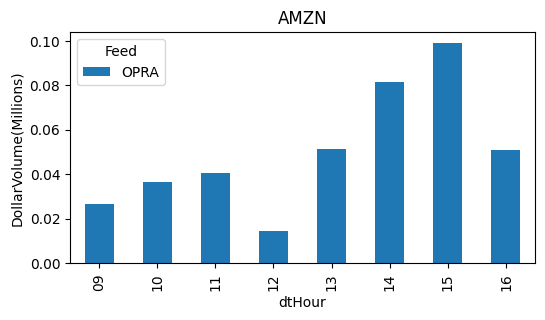

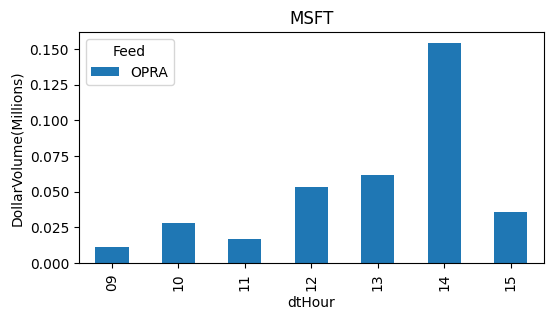

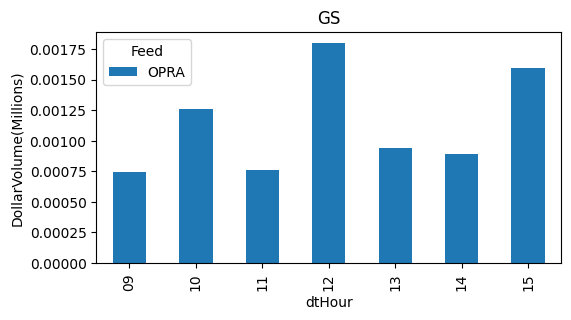

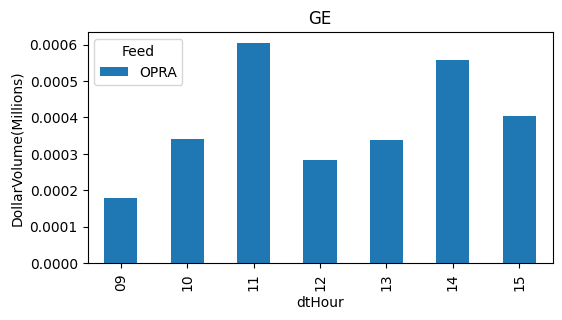

In [160]:
#generate visual using built-in pandas integration with matplotlib
# we use toPandas() here 
for one_t in sample_tickers:
    plot_pd.query(f"ProductUnderlier=='{one_t}'").pivot_table(index=["dtHour"], columns=["Feed"],values="DollarVolume(Millions)")\
    .plot(title=f"{one_t}",kind="bar", stacked='True', ylabel="DollarVolume(Millions)", figsize=(6, 3))

#BL: broke this by adding one more field - tried to fix it but gave up since i rarely use seaborn

## TRADES SECTION ##

In [161]:
#cover for order partial refills, replacing price with vwap price and timestamp with the latest filled part of the order
#we also make sure we only look for the fully filled orders, last LeavesQuantity=0 
vWAP_group_by_cols = ['OrderReferenceNumber','Product','ProductUnderlier','Side','Feed','f',"dtHour",'dt']
trade_df_grouped = trade_df.groupBy(vWAP_group_by_cols).agg(
    f.sum(f.col('Quantity')).alias('weight_sum'),
    f.sum(f.col('Quantity')).alias('Quantity'),
    f.sum(f.col('Quantity') * f.col('Price')).alias('weight_price_sum'),
    f.min('ReceiptTimestamp').alias('ReceiptTimestamp'),
    f.last(f.col('LeavesQuantity'),True).alias('Unfilled'),
    f.count(f.col('SequenceNumber')).alias('fill_count')
).withColumn('vWAP',f.col('weight_price_sum')/f.col('weight_sum')).cache()#.filter(f.col('Unfilled')<1).cache()
trade_df_grouped.where('ProductUnderlier=="AMZN" and fill_count between 3 and 5').orderBy(['fill_count','Product'],ascending=False).show(truncate=False)
sample_set={}
sample_set['Product']='AMZN  251219P00080000'
sample_set['dt']='2023-05-17'
sample_set['dtHour']='09'
trade_df.where(f"Product=='{sample_set['Product']}' and dt=='{sample_set['dt']}' and dtHour=='{sample_set['dtHour']}'").show(truncate=False)
trade_df_grouped.where(f"Product=='{sample_set['Product']}' and dt=='{sample_set['dt']}' and dtHour=='{sample_set['dtHour']}'").show(truncate=False)

+--------------------+---------------------+----------------+----+----+----+------+----------+-----------------------+-----------------------+----------------+-------------------+--------+----------+---------+
|OrderReferenceNumber|Product              |ProductUnderlier|Side|Feed|f   |dtHour|dt        |weight_sum             |Quantity               |weight_price_sum|ReceiptTimestamp   |Unfilled|fill_count|vWAP     |
+--------------------+---------------------+----------------+----+----+----+------+----------+-----------------------+-----------------------+----------------+-------------------+--------+----------+---------+
|null                |AMZN  251219P00080000|AMZN            |null|OPRA|opra|09    |2023-05-17|11.0000000000000000000 |11.0000000000000000000 |80.250000       |1684330408562334947|null    |5         |7.295455 |
|null                |AMZN  251219P00070000|AMZN            |null|OPRA|opra|10    |2023-05-18|5.0000000000000000000  |5.0000000000000000000  |23.350000       |1

In [162]:
expected_val = (7.3*1+7.3*2+7.3*2+7.29*5+7.3*1)/(1+2+2+5+1)
actual_val=float(trade_df_grouped.where(f"Product=='{sample_set['Product']}' and dt=='{sample_set['dt']}' and dtHour=='{sample_set['dtHour']}'").select('vWAP').toPandas().values[0][0])
print(round(expected_val,5),round(actual_val,5))
assert round(expected_val,5)==round(actual_val,5)

7.29545 7.29545


In [168]:
#create the union of trades and nbbo data to simulate as-of join 
# normalize list of columns for trades_df and nbbo_df, initialize missing columns as nulls
#we also add DataType column initialised as 1 for trades and 0 for nbbo to separate datasets
trade_df_grouped=trade_df_grouped\
    .withColumn('BidPrice',f.lit(None).cast(t.NullType()))\
    .withColumn('BidQuantity',f.lit(None).cast(t.NullType()))\
    .withColumn('AskPrice',f.lit(None).cast(t.NullType()))\
    .withColumn('AskQuantity',f.lit(None).cast(t.NullType()))\
    .withColumn('DataType',f.lit(1).cast(t.IntegerType()))\
    .withColumn('bid_ask_spread',f.lit(None).cast(t.NullType()))\
    .withColumn('mid_price',f.lit(None).cast(t.NullType()))
nbbo_df = nbbo_df.withColumn('vWAP',f.lit(None).cast(t.NullType()))\
    .withColumn('Quantity',f.lit(None).cast(t.NullType()))\
    .withColumn('Side',f.lit(None).cast(t.NullType()))\
    .withColumn('DataType',f.lit(0).cast(t.IntegerType()))

#union both dataframes, and make sure the names are order of columns are identical
#BL: i added Feed and f as helps to create a story later
select_cols = ["Feed","f",'Product','dtHour','vWAP','Quantity','Side','BidPrice','BidQuantity','AskPrice','AskQuantity','ReceiptTimestamp','DataType','dtHour','dt','bid_ask_spread','mid_price']
trade_nbbo_df = trade_df_grouped.select(select_cols)\
.union(nbbo_df.select(select_cols))\
.withColumn('ReceiptTimestampEST',f.from_utc_timestamp(f.from_unixtime(f.col('ReceiptTimestamp').cast(t.StringType())[0:10]),'America/New_York'))
trade_nbbo_df.show()

+----+----+--------------------+------+---------+--------------------+----+--------+-----------+--------+-----------+-------------------+--------+------+----------+--------------+---------+-------------------+
|Feed|   f|             Product|dtHour|     vWAP|            Quantity|Side|BidPrice|BidQuantity|AskPrice|AskQuantity|   ReceiptTimestamp|DataType|dtHour|        dt|bid_ask_spread|mid_price|ReceiptTimestampEST|
+----+----+--------------------+------+---------+--------------------+----+--------+-----------+--------+-----------+-------------------+--------+------+----------+--------------+---------+-------------------+
|OPRA|opra|AMD   230519C0009...|    14| 7.822632|19.00000000000000...|null|    null|       null|    null|       null|1684346791694420732|       1|    14|2023-05-17|          null|     null|2023-05-17 14:06:31|
|OPRA|opra|AI    240719C0001...|    09|11.058667|15.00000000000000...|null|    null|       null|    null|       null|1684331566510438770|       1|    09|2023-05

In [164]:
#select active Products to sample
ptile_win = Window.partitionBy('Feed').orderBy("d_count")
sample_trade_df=trade_df_grouped\
.groupBy('Product','Feed').agg(f.count('f').alias('d_count'))\
.withColumn('d_count_ptile',f.percent_rank().over(ptile_win))\
.orderBy(['d_count_ptile'],ascending=False).where("(Product like 'AM%') and d_count_ptile between 0.95 and 0.992")
print(sample_trade_df.count())
sample_products=[i.__getitem__('Product') for i in sample_trade_df.orderBy(['d_count_ptile'],ascending=False).take(50)]

576


In [165]:
from pyspark.sql.window import Window
#we are looking for the closest timestamp to the current row. 
lookup_window=Window.partitionBy('Product').orderBy("Feed","f",'ReceiptTimestamp','DataType').rowsBetween(Window.unboundedPreceding, Window.currentRow)
sample_product_list="'"+"','".join(sample_products)+"'"
sample_product_list

"'AMC   230616C00010000','AMZN  230526C00118000','AMZN  230526C00121000','AMZN  230526P00110000','AMC   230630P00004000','AMZN  231020C00140000','AMZN  230519P00107000','AMZN  230609P00108000','AMAT  230519C00135000','AMD   230519P00094000','AMGN  230616C00225000','AMZN  230519P00111000','AMZN  230526C00116000','AMD   230609C00105000','AMAT  230519C00120000','AMD   240119C00120000','AMZN  230915P00105000','AMZN  230519P00104000','AMD   230602C00104000','AMZN  231020C00120000','AMD   230616C00085000','AMD   230519P00110000','AMD   230616P00075000','AMC   230818P00004000','AMC   230519P00005500','AMC   230602C00006500','AMZN  230616P00115000','AMZN  240119P00100000','AMAT  230526C00130000','AMD   230623C00115000','AMD   230519C00108000','AMZN  230818C00125000','AMC   240119C00025000','AMD   230721C00110000','AMZN  230602C00118000','AMZN  230616P00090000','AMZN  230526C00105000','AMD   230519P00096000','AMZN  230721C00115000','AMZN  230519C00100000','AMZN  230609C00125000','AMZN  230630P0

In [171]:
cache_file_name = f"{s3_working_dir}/trade_nbbo_price_cache.parquet"
if False:
    # caclulate the price difference based on Nbbo midpoint
    trade_nbbo_price = trade_nbbo_df\
        .where(f'Product in ({sample_product_list})')\
        .withColumn('isTrade', (f.col('AskPrice').isNull())).select('Feed','f','Product','vWAP','Quantity','Side','ReceiptTimestamp','ReceiptTimestampEST','dtHour','dt','isTrade',
        f.last('AskPrice', True).over(lookup_window).alias('AskPriceNbbo'),
        f.last('BidPrice', True).over(lookup_window).alias('BidPriceNbbo'),        
        f.last('bid_ask_spread', True).over(lookup_window).alias('bid_ask_spread'),
        f.last('mid_price', True).over(lookup_window).alias('mid_price'),
        f.last(f.when(f.col('DataType') < 1, f.col('ReceiptTimestamp') ).otherwise(None), True).over(lookup_window).alias('TimestampNbbo')   ,
        f.last(f.when(f.col('DataType') == 1, f.md5(f.concat(f.col('ReceiptTimestamp'),f.lit("_"),f.col('Product')))).otherwise(None), True).over(lookup_window).alias('TradeId')         
        )\
        .withColumn('MidPrice', (f.col('AskPriceNbbo') + f.col('BidPriceNbbo'))/2)\
        .withColumn('ArrivalPriceImprovementBP', ((f.col('vWAP') -f.col('MidPrice'))/f.col('MidPrice') )*1000)
    union_partition_columns=['dt','Product']
    print(cache_file_name,trade_nbbo_price.columns)
    trade_nbbo_price.repartition(*union_partition_columns).write.partitionBy(*union_partition_columns)\
       .mode('overwrite').parquet(cache_file_name)
trade_nbbo_price=spark.read.parquet(cache_file_name)
print(cache_file_name,trade_nbbo_price.columns)

s3://demomayst/cache//trade_nbbo_price_cache.parquet ['Feed', 'f', 'vWAP', 'Quantity', 'Side', 'ReceiptTimestamp', 'ReceiptTimestampEST', 'dtHour', 'isTrade', 'AskPriceNbbo', 'BidPriceNbbo', 'bid_ask_spread', 'mid_price', 'TimestampNbbo', 'TradeId', 'MidPrice', 'ArrivalPriceImprovementBP', 'dt', 'Product']


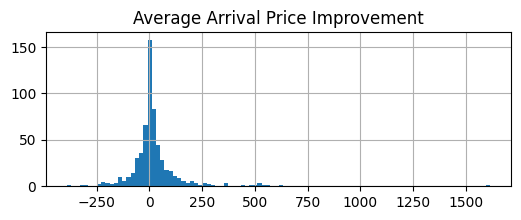

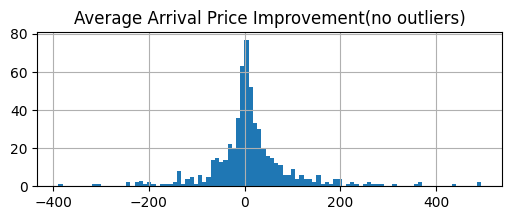

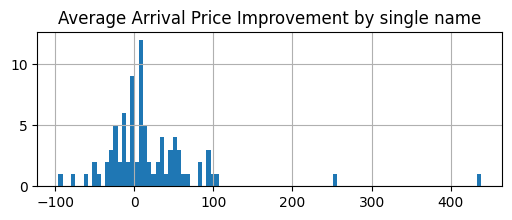

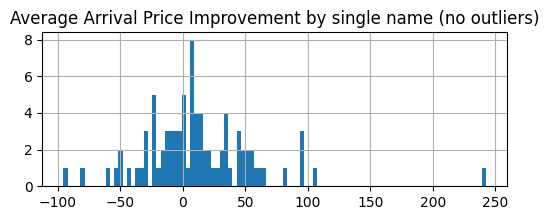

In [172]:
# please check if gap fill forward works properly and then we just remove filter on top to do this visual accross the board
# we use a few selected products only for visualisation purposes

right_tale_limit = 500
arrival_price_stats_pd=trade_nbbo_price.where("isTrade == True").groupby('dtHour','Feed','f','Product').agg(f.mean('ArrivalPriceImprovementBP')\
.alias('AvgArrivalPriceImprovementBP')).where("AvgArrivalPriceImprovementBP is not null").toPandas()

arrival_price_stats_less_oiutliers_pd=arrival_price_stats_pd.query(f"AvgArrivalPriceImprovementBP<{right_tale_limit}")
#arrival_price_stats_pd.groupby('Product').agg(f.mean('AvgArrivalPriceImprovementBP').alias('AvgArrivalPriceImprovementBP')).pandas_api()[["AvgArrivalPriceImprovementBP"]].astype(float).hist()
def graph_hist(l_df,l_title,bins=100,figsize=(6,2)):
    l_df.hist(bins=bins,figsize=figsize);plt.title(l_title);
    plt.suptitle('').set_visible(False)
graph_hist((arrival_price_stats_pd[['AvgArrivalPriceImprovementBP']].astype(float)),"Average Arrival Price Improvement")
graph_hist(arrival_price_stats_less_oiutliers_pd[['AvgArrivalPriceImprovementBP']].astype(float),"Average Arrival Price Improvement(no outliers)")
graph_hist(arrival_price_stats_pd.groupby('Product').agg(AvgArrivalPriceImprovementBP=("AvgArrivalPriceImprovementBP","mean")).astype(float),"Average Arrival Price Improvement by single name")
graph_hist(arrival_price_stats_less_oiutliers_pd.groupby('Product').agg(AvgArrivalPriceImprovementBP=("AvgArrivalPriceImprovementBP","mean")).astype(float),"Average Arrival Price Improvement by single name (no outliers)")

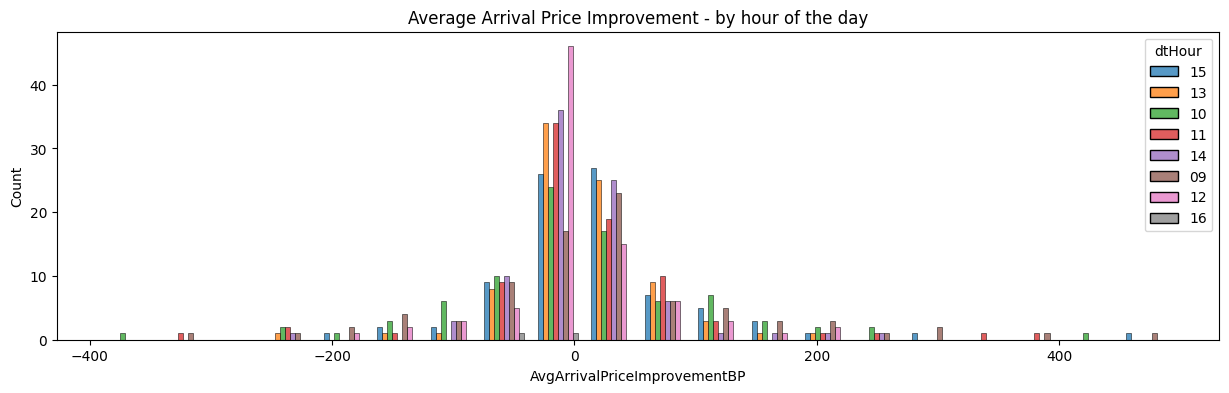

In [173]:
plt.figure(figsize=(15,4));
sns.histplot(arrival_price_stats_less_oiutliers_pd, x='AvgArrivalPriceImprovementBP', hue='dtHour',multiple='dodge', shrink=.75, bins=20)\
.set_title('Average Arrival Price Improvement - by hour of the day');

In [174]:
#pick few orders to sample to simulate "your own" trades
#trade_df.filter(f.col('OrderReferenceNumber')=='1000045252').show(10)
sample_where_clause="Product like 'AMZN%' and Feed=='OPRA' "
lookback_offset=10*1000*1000*1000*60
trade_stats_df=trade_nbbo_price.where("isTrade == True").where(f"{sample_where_clause}")\
.groupBy("ReceiptTimestamp","Product","Feed",'f','dt','dtHour','Side').agg(f.count('ReceiptTimestamp').alias('partial_count'),
                                                                  f.min('ReceiptTimestamp').alias('fill_start'),
                                                                  f.max('ReceiptTimestamp').alias('fill_end')
                                                                 )\
.select("*",
        (f.col('fill_start')-lookback_offset).alias('ts_start'),
        (f.col('fill_end')+lookback_offset).alias('ts_end'),
        f.round((f.col("ts_end")-f.col("ts_start"))/1000/1000/1000/60,1).alias('fill_duration_min')
       )
print(trade_stats_df.count())
trade_stats_df.orderBy('partial_count','fill_duration_min',ascending=False).orderBy('Product').show()
sample_trades=trade_stats_df.drop('fill_start','fill_end').join(trade_nbbo_price.where("isTrade == True").where(sample_where_clause).where('dtHour between "09" and "16" '),on=['ReceiptTimestamp',"Product",'dt','dtHour','Feed','f'])\
    .select('Product','dt','dtHour','Feed','f','ReceiptTimestamp','partial_count','ts_start','ts_end','fill_duration_min','vWAP' )
sample_trades.show(10)
print(sample_trades.count())
sample_trades_dict=sample_trades.orderBy("ReceiptTimestamp",ascending=False).take(30)


575
+-------------------+--------------------+----+----+----------+------+----+-------------+-------------------+-------------------+-------------------+-------------------+-----------------+
|   ReceiptTimestamp|             Product|Feed|   f|        dt|dtHour|Side|partial_count|         fill_start|           fill_end|           ts_start|             ts_end|fill_duration_min|
+-------------------+--------------------+----+----+----------+------+----+-------------+-------------------+-------------------+-------------------+-------------------+-----------------+
|1684343288280898064|AMZN  230519C0010...|OPRA|opra|2023-05-17|    13|null|            1|1684343288280898064|1684343288280898064|1684342688280898064|1684343888280898064|             20.0|
|1684429458316373936|AMZN  230519C0010...|OPRA|opra|2023-05-18|    13|null|            1|1684429458316373936|1684429458316373936|1684428858316373936|1684430058316373936|             20.0|
|1684332001678279399|AMZN  230519C0010...|OPRA|opra|2023

In [175]:
where_list_nbbo=[]
where_list_trades=[]
for one_trade_det in sample_trades_dict:
    product,ts_s,ts_e,ReceiptTimestamp=one_trade_det['Product'],one_trade_det['ts_start'],one_trade_det['ts_end'],one_trade_det['ReceiptTimestamp']
    where_list_nbbo.append(f"Product=='{product}' and (ReceiptTimestamp between {ts_s} and  {ts_e}) ")
    where_list_trades.append(f"Product=='{product}' and ReceiptTimestamp=='{ReceiptTimestamp}'")
where_nbbo_text = "("+') OR ('.join(where_list_nbbo)+")"
where_text_trades = "("+') OR ('.join(list(set(where_list_trades)))+")"
print(where_nbbo_text,where_text_trades)

(Product=='AMZN  230526C00118000' and (ReceiptTimestamp between 1684439452661814272 and  1684440652661814272) ) OR (Product=='AMZN  230519P00103000' and (ReceiptTimestamp between 1684438651534415513 and  1684439851534415513) ) OR (Product=='AMZN  230519P00107000' and (ReceiptTimestamp between 1684438300601381450 and  1684439500601381450) ) OR (Product=='AMZN  240315C00120000' and (ReceiptTimestamp between 1684438275795242592 and  1684439475795242592) ) OR (Product=='AMZN  230609P00116000' and (ReceiptTimestamp between 1684438035346422389 and  1684439235346422389) ) OR (Product=='AMZN  230609P00108000' and (ReceiptTimestamp between 1684437964789137430 and  1684439164789137430) ) OR (Product=='AMZN  230519P00104000' and (ReceiptTimestamp between 1684437909494705557 and  1684439109494705557) ) OR (Product=='AMZN  240119C00125000' and (ReceiptTimestamp between 1684437442206363312 and  1684438642206363312) ) OR (Product=='AMZN  230526C00105000' and (ReceiptTimestamp between 1684437356602454

In [176]:
nbbo_sample_df =nbbo_df.where(where_nbbo_text)
print(nbbo_sample_df.count())
sample_trades_df= sample_trades.where(where_text_trades)
print(sample_trades_df.count())

902681
30


In [177]:
nbbo_sample_pd   = nbbo_sample_df.toPandas()
sample_trades_pd = sample_trades_df.toPandas()

In [178]:
nbbo_sample_pd.set_index(['Product','ReceiptTimestamp']).sort_index().head(20)

f  Feed SequenceNumber  \
Product               ReceiptTimestamp                                 
AMZN  230519C00100000 1684436627852794416  opra  OPRA      589899908   
                      1684436627856651335  opra  OPRA      589905068   
                      1684436627860731877  opra  OPRA      589906902   
                      1684436627861664906  opra  OPRA      589907413   
                      1684436627871035225  opra  OPRA      589909569   
                      1684436627890802368  opra  OPRA      589913407   
                      1684436627956558875  opra  OPRA      589922331   
                      1684436627967955939  opra  OPRA      589923615   
                      1684436627968021303  opra  OPRA      589923640   
                      1684436627977586112  opra  OPRA      589926116   
                      1684436627978075414  opra  OPRA      589926215   
                      1684436627979794234  opra  OPRA      589926591   
                      1684436628015148356  opra  OPRA      589930066   
                      1684436628090924412  opra  OPRA      589942553   
                      1684436628614991664  opra  OPRA      589958342   
                      1684436630053867965  opra  OPRA      589968839   
                      1684436630054945357  opra  OPRA      589968842   
                      1684436630055005714  opra  OPRA      589968843   
                      1684436630055050715  opra  OPRA      589968844   
                      1684436630151199795  opra  OPRA      589969535   

                                                   dt                BidPrice  \
Product               ReceiptTimestamp                                          
AMZN  230519C00100000 1684436627852794416  2023-05-18  16.9000000000000000000   
                      1684436627856651335  2023-05-18  16.9000000000000000000   
                      1684436627860731877  2023-05-18  16.9000000000000000000   
                      1684436627861664906  2023-05-18  16.9000000000000000000   
                      1684436627871035225  2023-05-18  16.9000000000000000000   
                      1684436627890802368  2023-05-18  16.9000000000000000000   
                      1684436627956558875  2023-05-18  16.9000000000000000000   
                      1684436627967955939  2023-05-18  16.9000000000000000000   
                      1684436627968021303  2023-05-18  16.9000000000000000000   
                      1684436627977586112  2023-05-18  16.9000000000000000000   
                      1684436627978075414  2023-05-18  16.9000000000000000000   
                      1684436627979794234  2023-05-18  16.9000000000000000000   
                      1684436628015148356  2023-05-18  16.9000000000000000000   
                      1684436628090924412  2023-05-18  16.9000000000000000000   
                      1684436628614991664  2023-05-18  16.9000000000000000000   
                      1684436630053867965  2023-05-18  16.9000000000000000000   
                      1684436630054945357  2023-05-18  16.9000000000000000000   
                      1684436630055005714  2023-05-18  16.9000000000000000000   
                      1684436630055050715  2023-05-18  16.9000000000000000000   
                      1684436630151199795  2023-05-18  16.9000000000000000000   

                                           BidQuantity  \
Product               ReceiptTimestamp                   
AMZN  230519C00100000 1684436627852794416        363.0   
                      1684436627856651335        363.0   
                      1684436627860731877        363.0   
                      1684436627861664906        363.0   
                      1684436627871035225        363.0   
                      1684436627890802368        364.0   
                      1684436627956558875        378.0   
                      1684436627967955939        388.0   
                      1684436627968021303        398.0   
                      168443662797758611

In [179]:
sample_trades_pd.set_index(['Product','ReceiptTimestamp']).sort_index()

,,dt,dtHour,Feed,f,partial_count,ts_start,ts_end,fill_duration_min,vWAP
Product,ReceiptTimestamp,,,,,,,,,
AMZN 230519C00100000,1684437225314090900,2023-05-18,15,OPRA,opra,1,1684436625314090900,1684437825314090900,20.0,17.482286
AMZN 230519P00103000,1684439251534415513,2023-05-18,15,OPRA,opra,1,1684438651534415513,1684439851534415513,20.0,0.010000
AMZN 230519P00104000,1684438509494705557,2023-05-18,15,OPRA,opra,1,1684437909494705557,1684439109494705557,20.0,0.010000
AMZN 230519P00107000,1684438900601381450,2023-05-18,15,OPRA,opra,1,1684438300601381450,1684439500601381450,20.0,0.010000
AMZN 230519P00111000,1684437066573960103,2023-05-18,15,OPRA,opra,1,1684436466573960103,1684437666573960103,20.0,0.019202
AMZN 230526C00105000,1684437956602454282,2023-05-18,15,OPRA,opra,1,1684437356602454282,1684438556602454282,20.0,12.625000
AMZN 230526C00118000,1684440052661814272,2023-05-18,16,OPRA,opra,1,1684439452661814272,1684440652661814272,20.0,2.130000
AMZN 230526C00121000,1684436600673964567,2023-05-18,15,OPRA,opra,1,1684436000673964567,1684437200673964567,20.0,0.902242
AMZN 230526P00102000,1684437091165177211,2023-05-18,15,OPRA,opra,1,1684436491165177211,1684437691165177211,20.0,0.040000


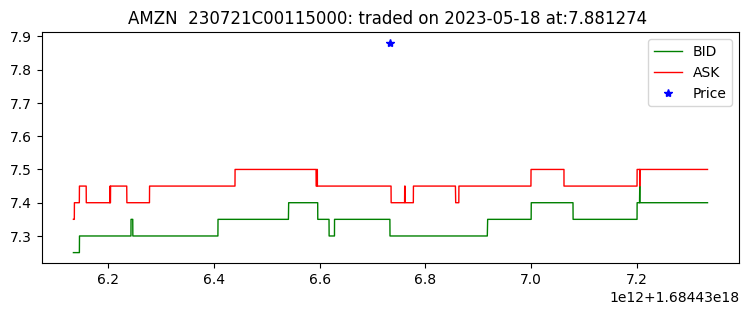

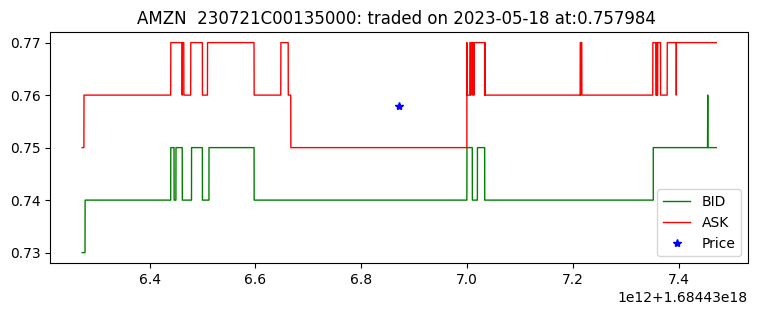

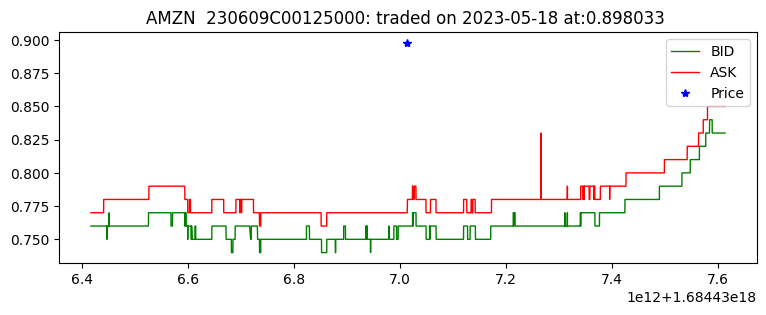

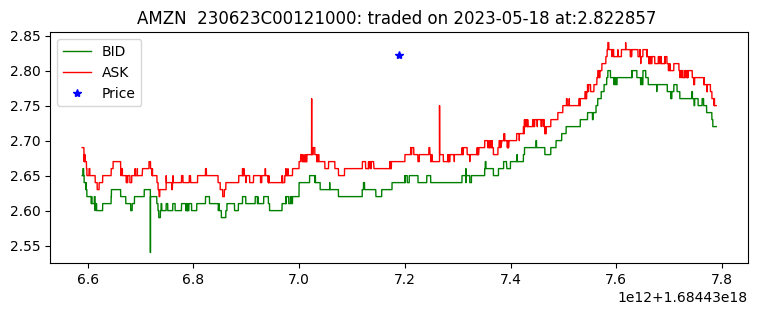

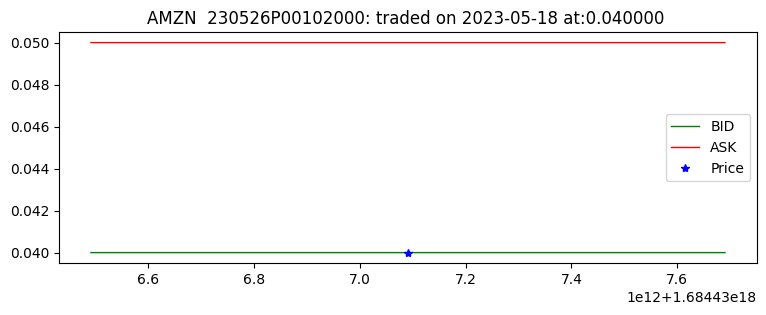

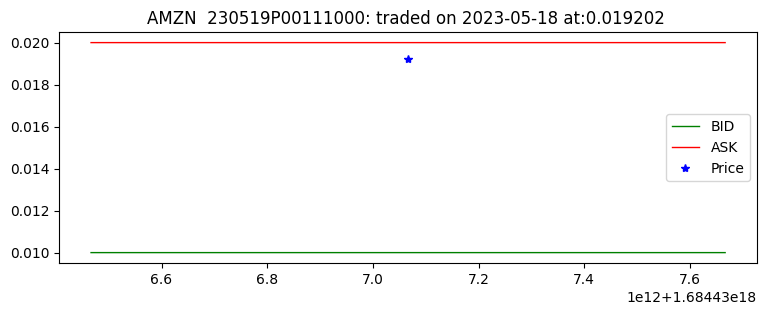

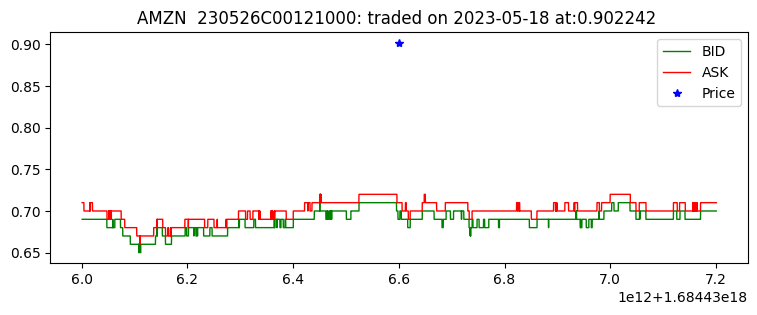

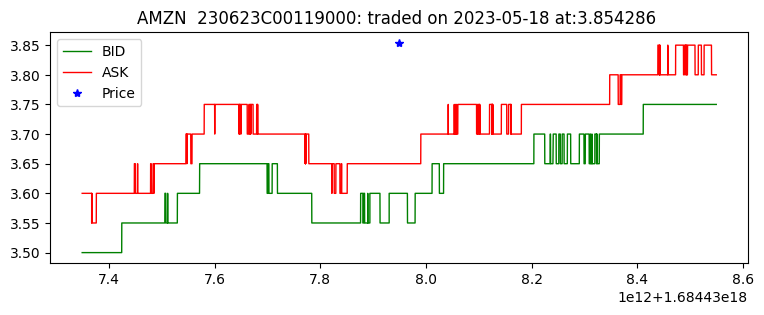

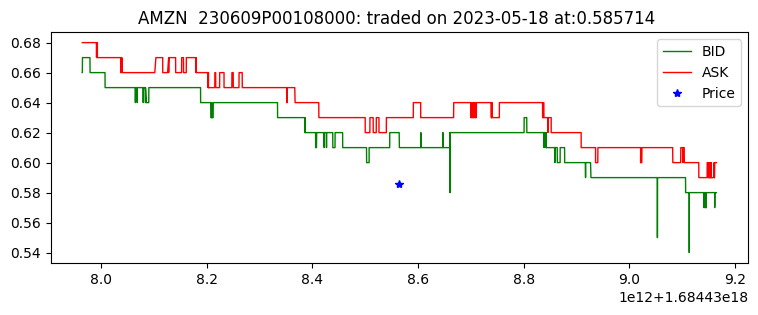

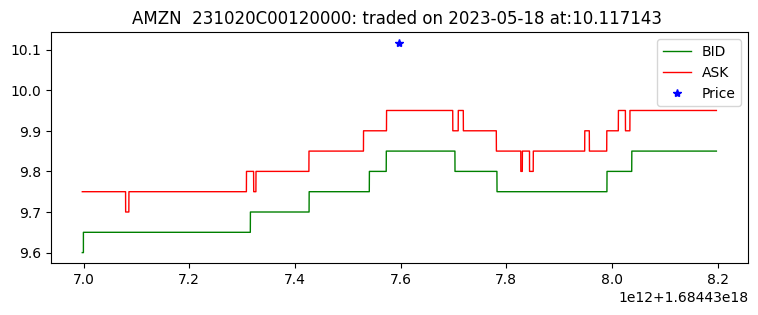

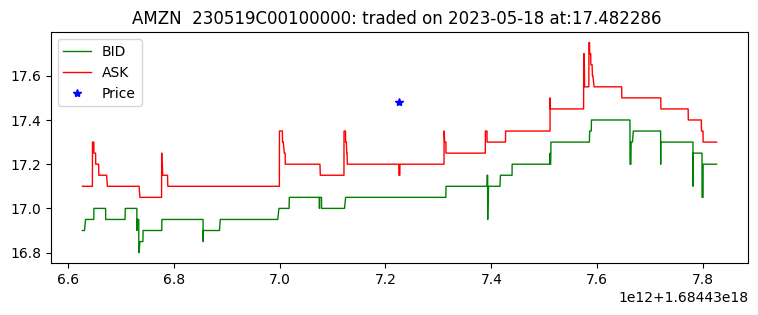

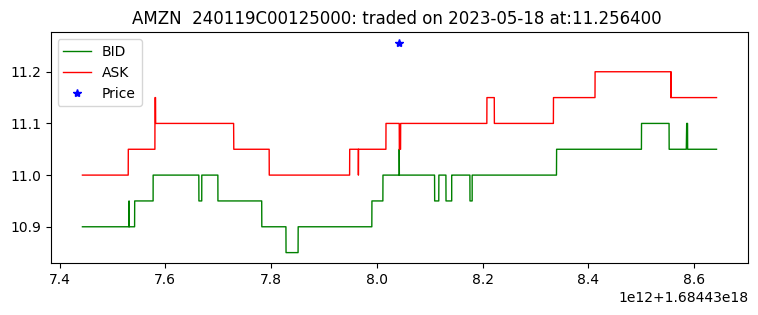

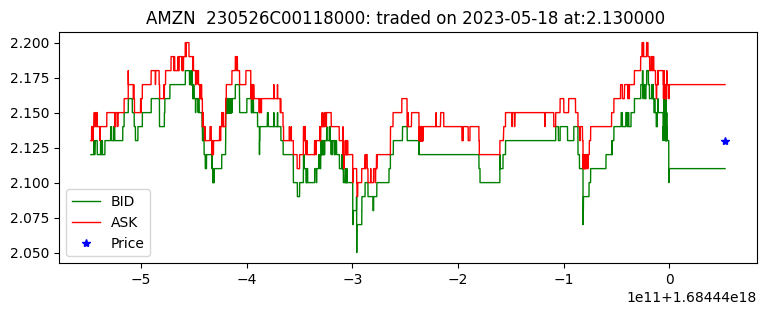

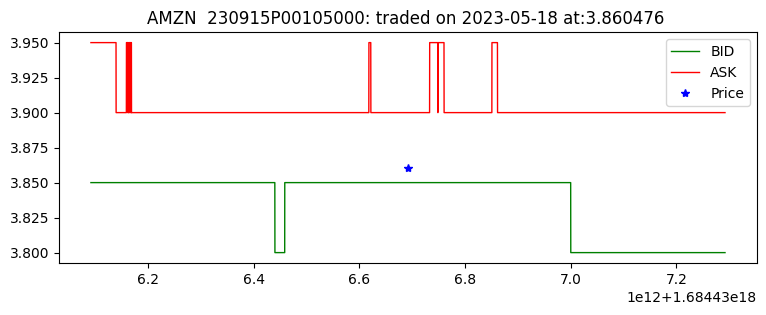

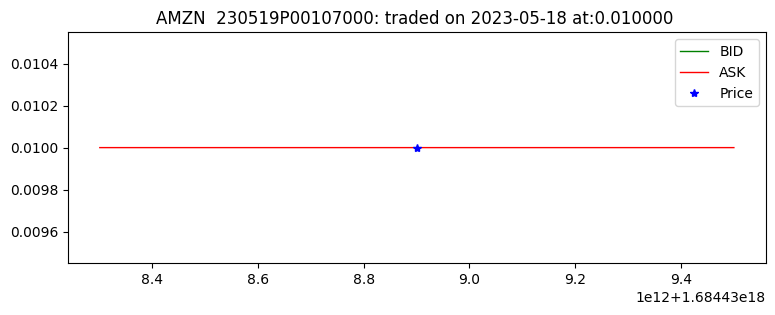

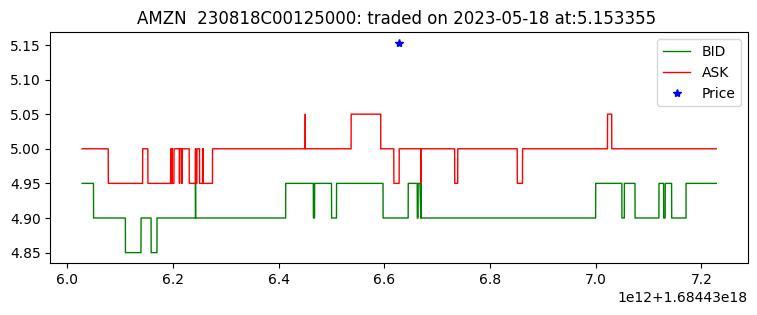

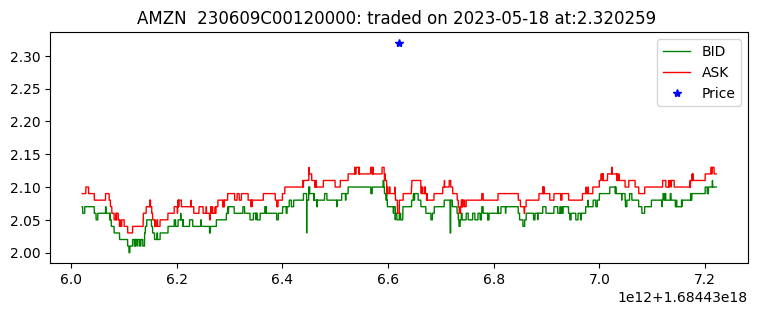

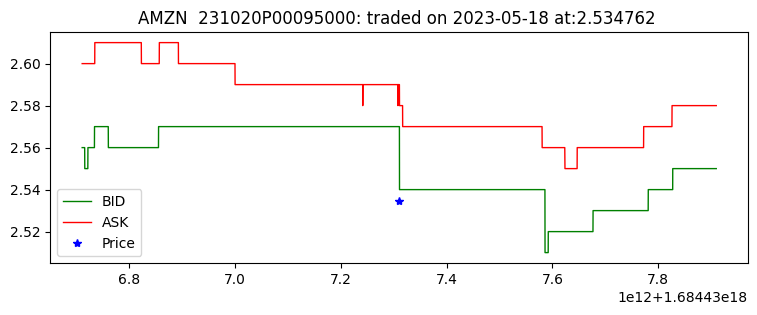

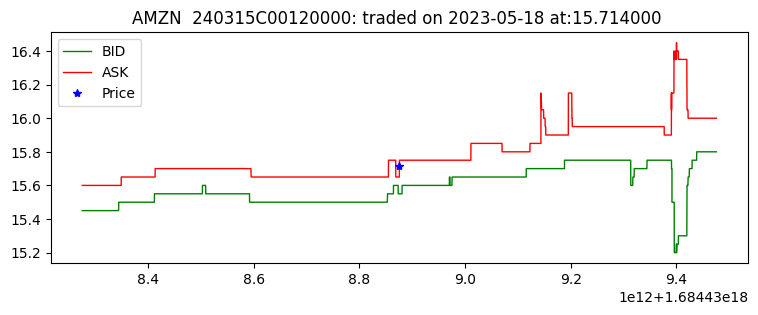

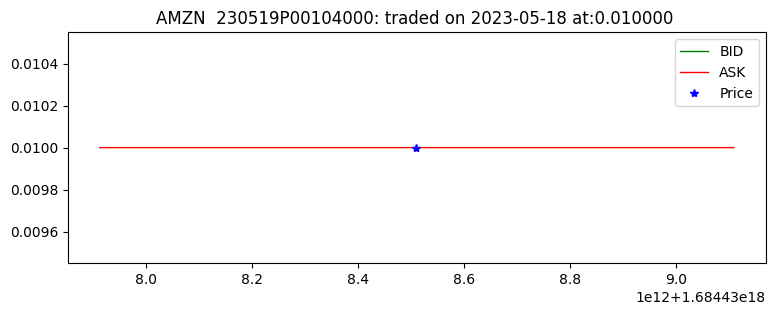

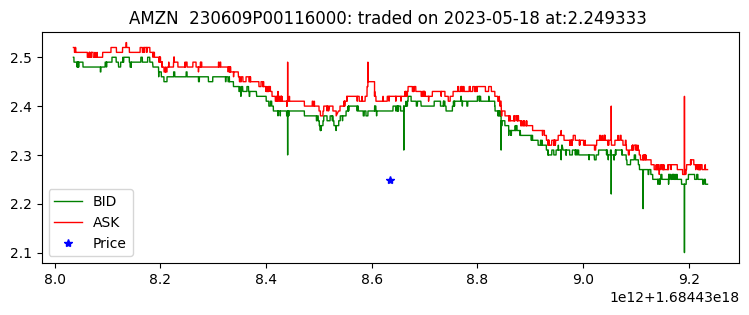

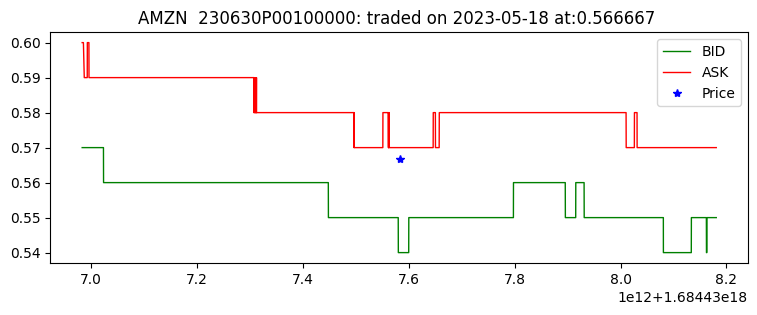

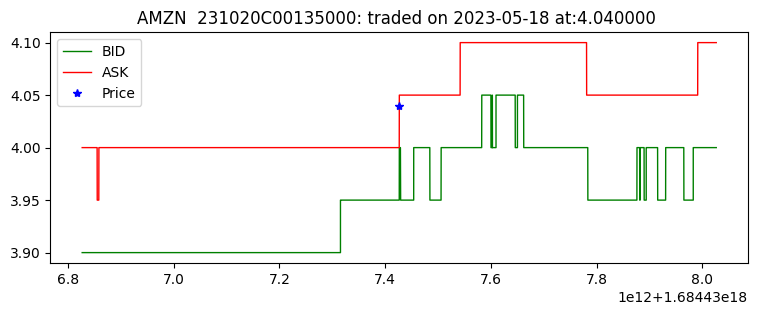

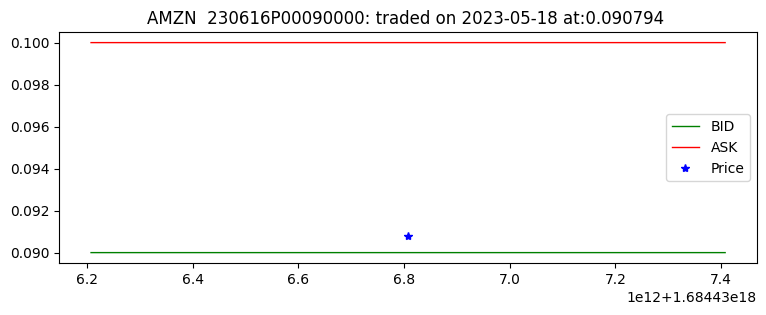

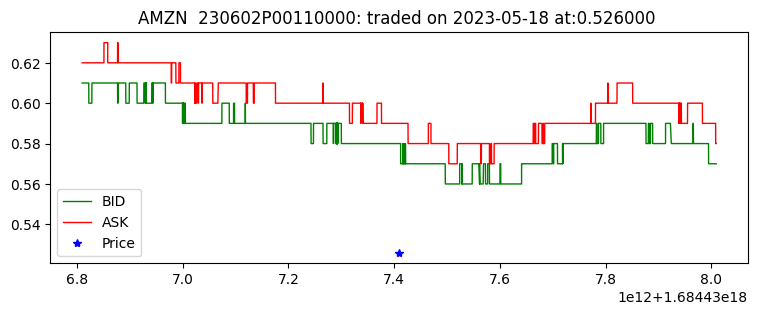

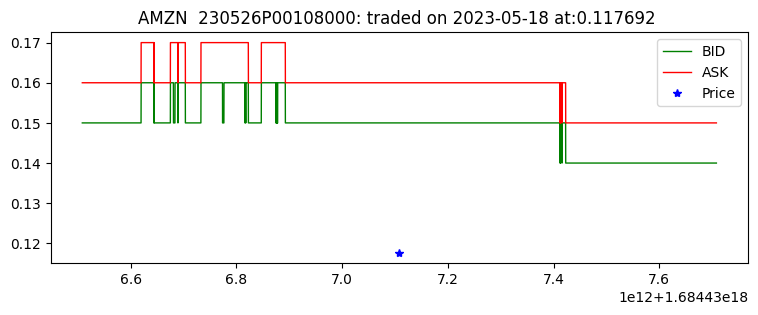

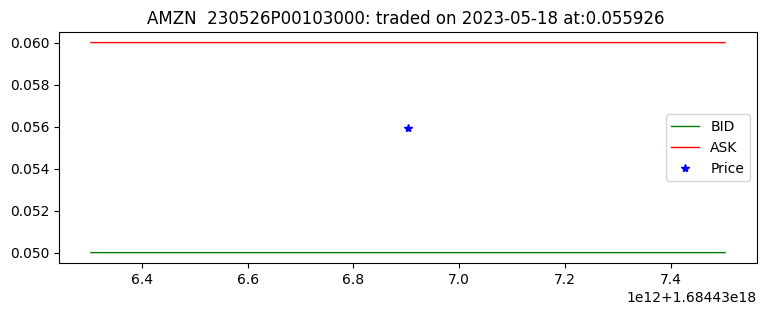

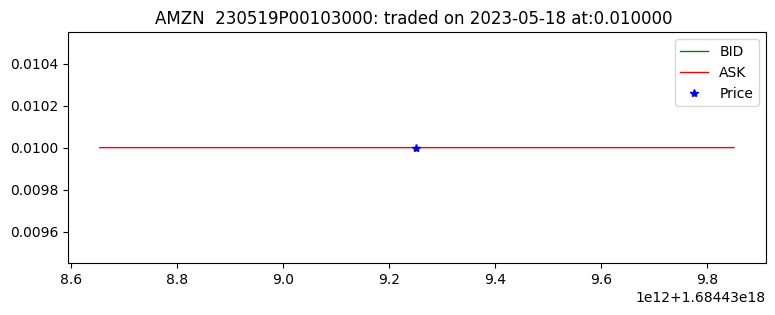

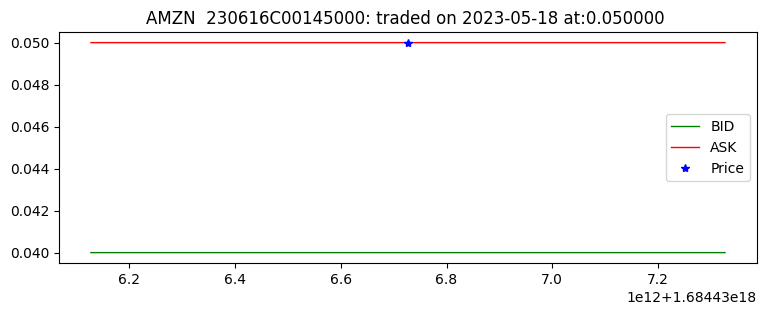

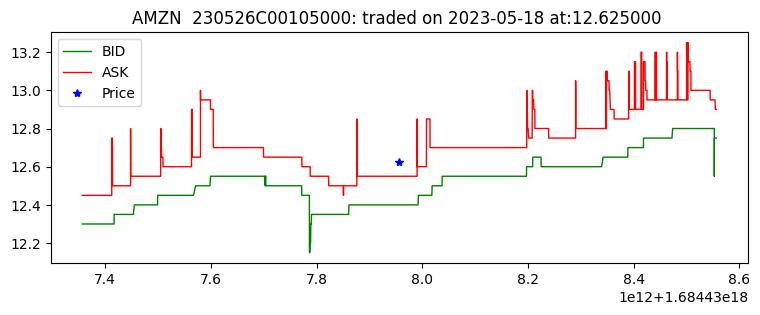

In [291]:
def get_before_after_metrics(l_df,trade_ts,trade_price,isAgg):
    l_df['trd_ts']=trade_ts
    l_df['before_after']=((l_df['ReceiptTimestamp']-l_df['trd_ts'])>0)*1
    l_df['before_after_disp'] = l_df['before_after'].apply(lambda x: 'After' if x > 0 else 'Before')

    l_df['trade_price']=trade_price
    if isAgg:
        ret_pd = l_df.groupby(['before_after','before_after_disp']).agg(QuotedSpread=('bid_ask_spread', lambda x: x.mean())
                                           ,MidPoint=('mid_price', lambda x: x.mean())
                                           ,TradePrice=('trade_price', lambda x: x.mean())
                                          )
    else:
        ret_pd = l_df.rename(columns={"bid_ask_spread":"QuotedSpread","mid_price":"MidPoint","trade_price":"TradePrice"})
    ret_pd['EffectiveSpread']=ret_pd['MidPoint']-ret_pd['TradePrice']
    ret_pd['EffectiveVsQuotedSpread']=np.where(ret_pd['QuotedSpread'].astype(float)==float(0),1,(ret_pd['EffectiveSpread'].astype(float)/ret_pd['QuotedSpread'].astype(float))*100)
    return(ret_pd)
    
plt.rcParams["figure.figsize"] = (9,3)
market_impact_results=[]
for one_ord in sample_trades_pd[['Product','ts_start','ts_end','dt','vWAP','ReceiptTimestamp']].drop_duplicates().dropna().iterrows():
    prod=one_ord[1].Product
    ts_start = (one_ord[1].ts_start)
    ts_end = (one_ord[1].ts_end)
    trade_ts = (one_ord[1].ReceiptTimestamp)
    trade_price = (one_ord[1].vWAP)
    dt_tr = str(one_ord[1]['dt'])
    one_pd = nbbo_sample_pd[['BidPrice','AskPrice','Product','ReceiptTimestamp','bid_ask_spread','mid_price']].query(f"Product=='{prod}'").query(f"ReceiptTimestamp>={ts_start}").query(f"ReceiptTimestamp<={ts_end}").sort_index()
    market_impact_results.append(get_before_after_metrics(one_pd.copy(deep=True),trade_ts,trade_price,isAgg=False))
    plot_pd =pd.DataFrame([one_ord[1]]).set_index(['Product','ReceiptTimestamp']).join(one_pd.set_index(['Product','ReceiptTimestamp']),how='outer').drop(columns=['dt','ts_start','ts_end']).astype(float)
    
    plot_title = f"{prod}: traded on {dt_tr} at:{trade_price} "
    #one_pd[['BidPrice','Price','AskPrice']].plot(figsize=(10,3),title=plot_title)
    plt.plot(plot_pd.reset_index()['ReceiptTimestamp'],plot_pd['BidPrice'].ffill(), marker='', color='green', linewidth=1, label="BID")
    plt.plot(plot_pd.reset_index()['ReceiptTimestamp'],plot_pd['AskPrice'].ffill(), marker='', color='red', linewidth=1, label="ASK")
    plt.plot(plot_pd.reset_index()['ReceiptTimestamp'],plot_pd['vWAP'], marker='*', color='blue', linewidth=0, label="Price")
    plt.legend()
    plt.title(plot_title)
    plt.show()
    
       

array([<Axes: title={'center': 'After'}>,
       <Axes: title={'center': 'Before'}>], dtype=object)

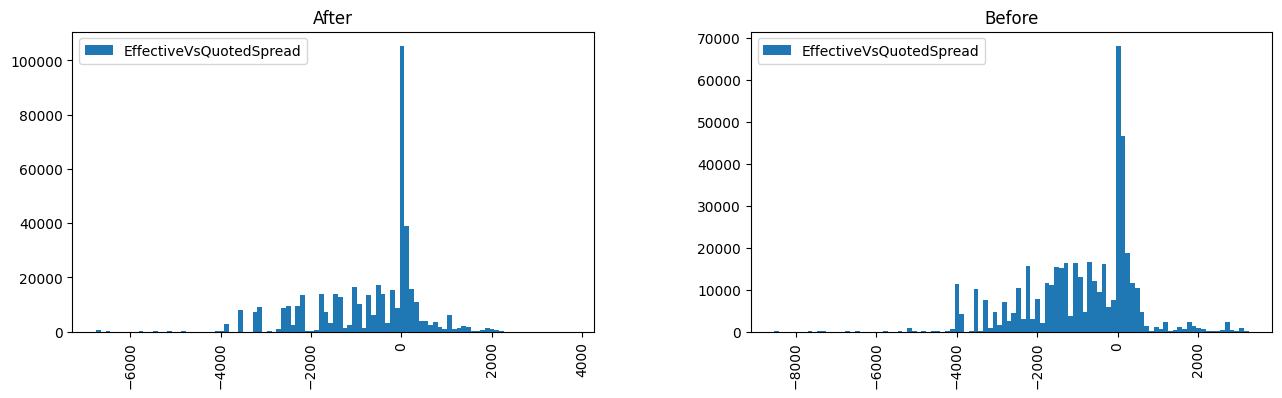

In [305]:
pd.concat(market_impact_results).dropna().hist('EffectiveVsQuotedSpread', by='before_after_disp',bins=100,legend=True,figsize=(15,4))

In [306]:
#calculate price difference vs Close
#adding necessary time columns
trade_df_grouped = trade_df_grouped\
.withColumn('ReceiptTimestampEST',f.from_utc_timestamp(f.from_unixtime(f.col('ReceiptTimestamp').cast(t.StringType())[0:10]),'America/New_York'))\
.withColumn('ReceiptTimestampESTDay',f.date_format(f.col('ReceiptTimestampEST'),'yyyy-MM-dd'))\
.withColumn('ReceiptTimestampESTTime',f.date_format(f.col('ReceiptTimestampEST'),'HH:mm:ss'))\
.withColumn('ReceiptTimestampESTWorkingHours',f.when( (f.col('ReceiptTimestampESTTime')>='09:30:00') & (f.col('ReceiptTimestampESTTime')<'16:00:00'), 1).otherwise(0))
trade_df_grouped.show(10)

+--------------------+--------------------+----------------+----+----+----+------+----------+--------------------+--------------------+----------------+-------------------+--------+----------+--------+--------+-----------+--------+-----------+--------+--------------+---------+-------------------+----------------------+-----------------------+-------------------------------+
|OrderReferenceNumber|             Product|ProductUnderlier|Side|Feed|   f|dtHour|        dt|          weight_sum|            Quantity|weight_price_sum|   ReceiptTimestamp|Unfilled|fill_count|    vWAP|BidPrice|BidQuantity|AskPrice|AskQuantity|DataType|bid_ask_spread|mid_price|ReceiptTimestampEST|ReceiptTimestampESTDay|ReceiptTimestampESTTime|ReceiptTimestampESTWorkingHours|
+--------------------+--------------------+----------------+----+----+----+------+----------+--------------------+--------------------+----------------+-------------------+--------+----------+--------+--------+-----------+--------+-----------+---

In [184]:
trade_df_grouped.printSchema()

root
 |-- OrderReferenceNumber: string (nullable = true)
 |-- Product: string (nullable = true)
 |-- ProductUnderlier: string (nullable = true)
 |-- Side: string (nullable = true)
 |-- Feed: string (nullable = true)
 |-- f: string (nullable = true)
 |-- dtHour: string (nullable = true)
 |-- dt: date (nullable = true)
 |-- weight_sum: decimal(38,19) (nullable = true)
 |-- Quantity: decimal(38,19) (nullable = true)
 |-- weight_price_sum: decimal(38,6) (nullable = true)
 |-- ReceiptTimestamp: long (nullable = true)
 |-- Unfilled: decimal(37,19) (nullable = true)
 |-- fill_count: long (nullable = false)
 |-- vWAP: decimal(38,6) (nullable = true)
 |-- BidPrice: void (nullable = true)
 |-- BidQuantity: void (nullable = true)
 |-- AskPrice: void (nullable = true)
 |-- AskQuantity: void (nullable = true)
 |-- DataType: integer (nullable = false)
 |-- bid_ask_spread: void (nullable = true)
 |-- mid_price: void (nullable = true)
 |-- ReceiptTimestampEST: timestamp (nullable = true)
 |-- ReceiptT

In [185]:
#define window
daily_window=Window.partitionBy('Product','ReceiptTimestampESTDay','Side').orderBy('ReceiptTimestampEST').rowsBetween(Window.unboundedPreceding, Window.unboundedFollowing)

#run aggregation to compare price improvements for AMZN stock
#vs daily Close price 
#vs daily max price
#vs daily max price during exchange working hours 
AMZN_price_imp = trade_df_grouped.filter(f.col('ProductUnderlier')=='AMZN').select(
    'Product','Side','vWAP','ReceiptTimestampESTDay','ReceiptTimestampESTTime','ReceiptTimestampESTWorkingHours', 
    f.last(f.when(f.col('ReceiptTimestampESTWorkingHours')>0, f.col('vWAP')).otherwise(None),True).over(daily_window).alias('vWAPClose'),
    f.max('vWAP').over(daily_window).alias('vWAPDaily'),
    f.max(f.when(f.col('ReceiptTimestampESTWorkingHours')>0, f.col('vWAP')).otherwise(None)).over(daily_window).alias('vWAPDailyWorkingHours')                        
).withColumn('ArrivalPriceImprovementBPvsClose', (f.col('vWAP') - f.col('vWAPClose'))*1000)\
.withColumn('ArrivalPriceImprovementBPvsDaily', (f.col('vWAP') - f.col('vWAPDaily'))*1000)\
.withColumn('ArrivalPriceImprovementBPvsDailyWH', (f.col('vWAP') - f.col('vWAPDailyWorkingHours'))*1000)
AMZN_price_imp.show(10)

+--------------------+----+---------+----------------------+-----------------------+-------------------------------+---------+---------+---------------------+--------------------------------+--------------------------------+----------------------------------+
|             Product|Side|     vWAP|ReceiptTimestampESTDay|ReceiptTimestampESTTime|ReceiptTimestampESTWorkingHours|vWAPClose|vWAPDaily|vWAPDailyWorkingHours|ArrivalPriceImprovementBPvsClose|ArrivalPriceImprovementBPvsDaily|ArrivalPriceImprovementBPvsDailyWH|
+--------------------+----+---------+----------------------+-----------------------+-------------------------------+---------+---------+---------------------+--------------------------------+--------------------------------+----------------------------------+
|AMZN  230519C0005...|null|64.800000|            2023-05-17|               10:23:42|                              1|65.550000|65.550000|            65.550000|                     -750.000000|                     -750.000

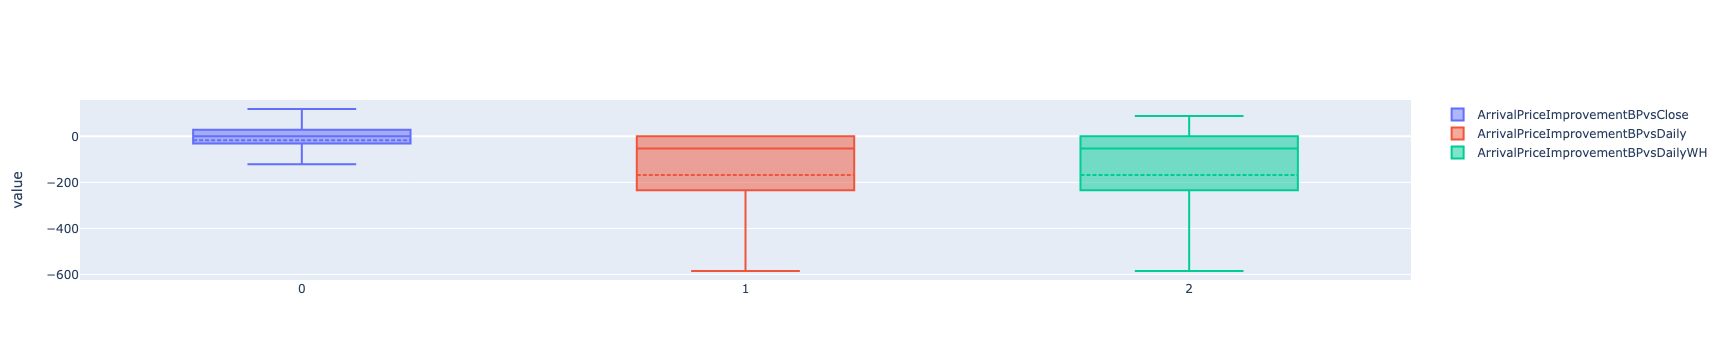

In [311]:
AMZN_price_imp.pandas_api()[['ArrivalPriceImprovementBPvsClose','ArrivalPriceImprovementBPvsDaily','ArrivalPriceImprovementBPvsDailyWH']].astype(float)\
.boxplot(orientation='v')

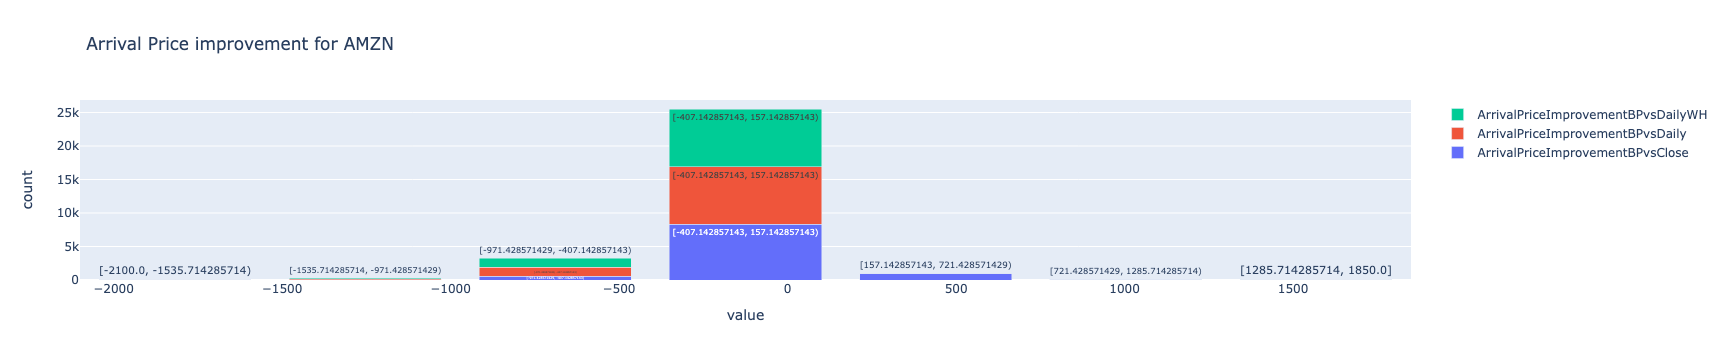

In [310]:
AMZN_price_imp.pandas_api()[['ArrivalPriceImprovementBPvsClose','ArrivalPriceImprovementBPvsDaily','ArrivalPriceImprovementBPvsDailyWH']].astype(float)\
    .hist(bins=7,title='Arrival Price improvement for AMZN')